In [1]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd

import time
import collections
import warnings

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf

from invisible_cities.core.core_functions import in_range, shift_to_bin_centers
from invisible_cities.core.stat_functions import poisson_sigma

from antea.utils.map_functions import correction_writer, load_corrections

In [3]:
### Useful parameters for plots
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 15, 12
plt.rcParams['figure.max_open_warning']= 0
default_cmap = "viridis"

In [4]:
## functions to fit
def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [ ]:
def gauss_seed(x, y, sigma_rel=0.05):
    """
    Estimate the seed for a gaussian fit to the input data.
    """
    y_max  = np.argmax(y) # highest bin
    x_max  = x[y_max]
    sigma  = sigma_rel * x_max
    amp    = y_max * (2 * np.pi)**0.5 * sigma * np.diff(x)[0]
    seed   = amp, x_max, sigma
    return seed

def relative_errors(values, errors, default=0, percentual=False):
    """
    Compute relative errors from input values with safety checks.
    If the relative error cannot be computed, a default value is
    used. The errors can be in percent if the `percentual`
    argument is True.
    """
    ok         = values != 0
    scale      = 100 if percentual else 1
    rel_e      = np.empty_like(values)
    rel_e[ ok] = errors[ok] / np.abs(values[ok]) * scale
    rel_e[~ok] = default
    return rel_e

In [ ]:
rad_depth = 30
z_min     = -972.5
z_max     = 972.5
rad_min   = 380

n_files        = 200
folder         = '/path/to/energy_map/files'
file_base_name = 'energy_map_file'

In [12]:
true_r1, true_r2, true_phi1, true_phi2, true_z1, true_z2 = [], [], [], [], [], []
reco_r1, reco_r2, reco_phi1, reco_phi2, reco_z1, reco_z2 = [], [], [], [], [], []
events = []
sns_response1, sns_response2 = [], []

for f in range(0, n_files):
    filename = folder + file_base_name + '.{0}.npz'.format(f)
    try:
        d = np.load(filename)
    except:
        print('File {} not existing'.format(filename))
        continue 
        
    true_r1   = np.concatenate((true_r1,   d['a_true_r1'] - rad_min))
    true_phi1 = np.concatenate((true_phi1, d['a_true_phi1']))
    true_z1   = np.concatenate((true_z1,   d['a_true_z1']))   
    true_r2   = np.concatenate((true_r2,   d['a_true_r2'] - rad_min))
    true_phi2 = np.concatenate((true_phi2, d['a_true_phi2']))
    true_z2   = np.concatenate((true_z2,   d['a_true_z2']))
        
    reco_r1   = np.concatenate((reco_r1,   d['a_reco_r1'] - rad_min))
    reco_phi1 = np.concatenate((reco_phi1, d['a_reco_phi1']))  
    reco_z1   = np.concatenate((reco_z1,   d['a_reco_z1']))   
    reco_r2   = np.concatenate((reco_r2,   d['a_reco_r2'] - rad_min))
    reco_phi2 = np.concatenate((reco_phi2, d['a_reco_phi2']))  
    reco_z2   = np.concatenate((reco_z2,   d['a_reco_z2']))
    
    sns_response1 = np.concatenate((sns_response1, d['a_sns_response1']))
    sns_response2 = np.concatenate((sns_response2, d['a_sns_response2']))
            
    events = np.concatenate((events, d['a_event_ids']))
        
true_r1   = np.array(true_r1)
true_r2   = np.array(true_r2)

valid1 = (true_phi1<1.e9)
valid2 = (true_phi2<1.e9)

true_r1 = true_r1[valid1]
true_phi1 = np.array(true_phi1)[valid1]
true_z1   = np.array(true_z1)[valid1]

reco_r1   = np.array(reco_r1)[valid1]
reco_phi1 = np.array(reco_phi1)[valid1]
reco_z1   = np.array(reco_z1)[valid1]

true_r2   = true_r2[valid2]
true_phi2 = np.array(true_phi2)[valid2]
true_z2   = np.array(true_z2)[valid2]

reco_r2   = np.array(reco_r2)[valid2]
reco_phi2 = np.array(reco_phi2)[valid2]
reco_z2   = np.array(reco_z2)[valid2]

sns_response1 = np.array(sns_response1)[valid1]
sns_response2 = np.array(sns_response2)[valid2]

events = np.array(events)

In [13]:
true_x1 = true_r1 * np.cos(true_phi1)
reco_x1 = reco_r1 * np.cos(reco_phi1)
true_y1 = true_r1 * np.sin(true_phi1)
reco_y1 = reco_r1 * np.sin(reco_phi1)
true_x2 = true_r2 * np.cos(true_phi2)
reco_x2 = reco_r2 * np.cos(reco_phi2)
true_y2 = true_r2 * np.sin(true_phi2)
reco_y2 = reco_r2 * np.sin(reco_phi2)

### change by hand phi reconstructed as true=~3.14, reco~=-3.14
reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.] = -reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.]
reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.] = -reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.]

In [15]:
reco_z       = np.concatenate((reco_z1, reco_z2))
reco_r       = np.concatenate((reco_r1, reco_r2))
sns_response = np.concatenate((sns_response1, sns_response2))  

In [17]:
Lrange = z_min, z_max
Rrange = 0, rad_depth
Lnbins = [30, 40, 40]
Rnbins = [6, 12, 15]
nL, nR  =    3,   3

In [18]:
def display_matrix(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
    else:
        mask = mask.flatten()
        
    z, x, y, p = plt.hist2d(x_[mask], y_[mask], (x_binning, y_binning), 
                            weights = z_[mask], **kwargs)
    x = shift_to_bin_centers(x)
    y = shift_to_bin_centers(y)
    h  = (z, x, y, p)
    return h, plt.colorbar()

In [20]:
Lbins    = {n: np.linspace(*Lrange,   n     + 1) for n in Lnbins}
Lcenters = {n: shift_to_bin_centers(bins)         for n, bins in Lbins.items()}
Lpitch   = {n: np.diff(bins)[0]                   for n, bins in Lbins.items()}
Rbins    = {n: np.linspace(*Rrange,   n     + 1) for n in Rnbins}
Rcenters = {n: shift_to_bin_centers(bins)         for n, bins in Rbins.items()}
Rpitch   = {n: np.diff(bins)[0]                   for n, bins in Rbins.items()}

correction_filename  = '/path/to/correction/geo_corr.h5'
correction_filenames = {}
n = 0
for pL, pR in zip(Lpitch.items(), Rpitch.items()):
    correction_filenames[n] = correction_filename.replace(".h5", "_GEO{pL:.1f}mm_{pR:.1f}mm.h5")
    n += 1

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)


/Users/paola/prova_thr2.h5


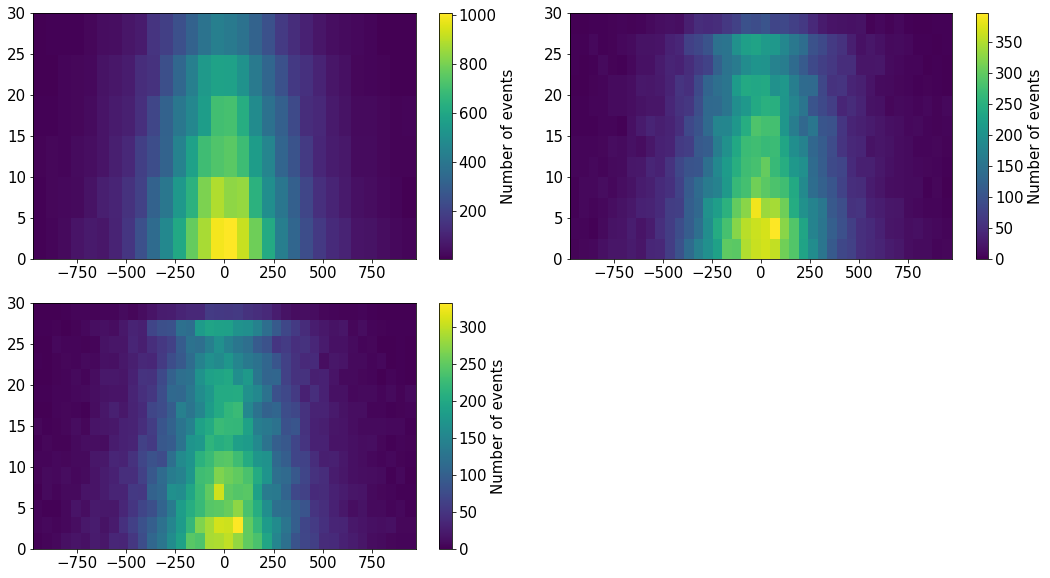

In [21]:
Nevt = {}
i    = 1
for nL, nR in zip(Lnbins, Rnbins):
    lbins  = Lbins [nL]
    rbins  = Rbins [nR]
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]

    plt.subplot(3, 2, i)
    nevt, *_ = plt.hist2d(reco_z, reco_r, (lbins, rbins))
    plt.colorbar().set_label("Number of events")

    Nevt[(nL, nR)]  = nevt
    i       += 1

plt.tight_layout()

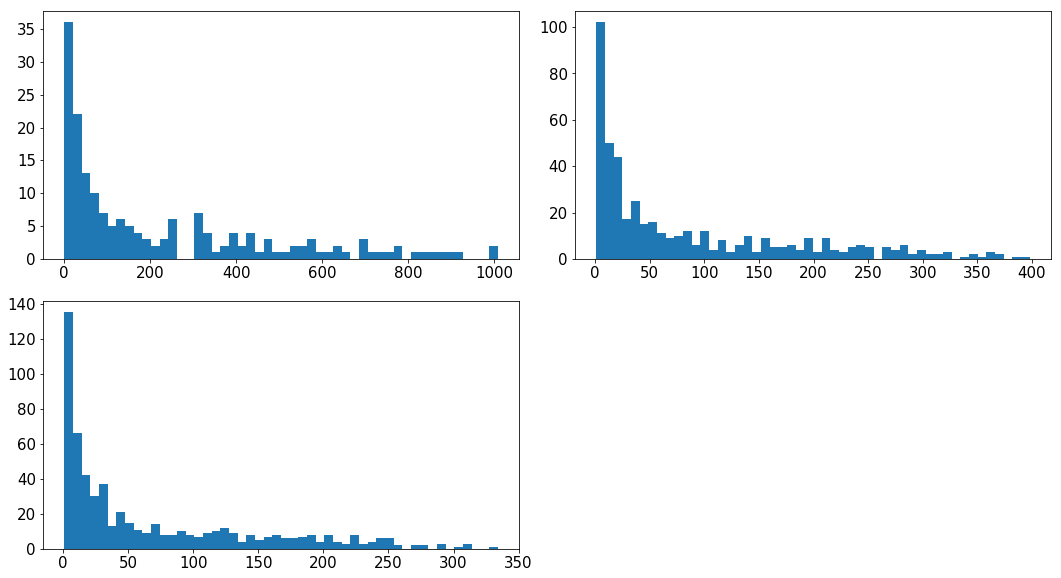

In [22]:
i = 1
for iL, iR in zip(Lnbins, Rnbins):
    nevt     = Nevt[(iL, iR)]
    lpitch  = Lpitch[iL]
    rpitch  = Rpitch[iR]
    nevt_max = int(np.max(nevt))

    plt.subplot(3, 2, i)
    plt.hist(nevt.flatten(), 50, (1, nevt_max + 1))
    i += 1

plt.tight_layout()

In [23]:
Eave  = {}
Eaveu = {}

E_mean  = {}
Eu_mean = {}
E_std   = {}
Eu_std  = {}

E_min  = {}
E_max  = {}
Eu_min = {}
Eu_max = {}


for nL, nR in zip(Lnbins, Rnbins):
    
    *_, Eave_, Eaveu_ = fitf.profileXY(reco_z, reco_r, sns_response, nL, nR, Lrange, Rrange)
    Eaveu_            = relative_errors(Eave_, Eaveu_, percentual=True)   
    #Eok               = Eave_ > 1e3
    Eok               = Eave_ > 0.
   
    Eave   [(nL, nR)] = Eave_
    Eaveu  [(nL, nR)] = Eaveu_
    
    E_mean [(nL, nR)] = np.mean(Eave_ [Eok])
    E_std  [(nL, nR)] = np.std (Eave_ [Eok])

    Eu_mean[(nL, nR)] = np.mean(Eaveu_[Eok])
    Eu_std [(nL, nR)] = np.std (Eaveu_[Eok])
    
    E_min  [(nL, nR)] =      E_mean[(nL, nR)] - 3.0 *  E_std[(nL, nR)]
    E_max  [(nL, nR)] =      E_mean[(nL, nR)] + 3.0 *  E_std[(nL, nR)]

    Eu_min [(nL, nR)] = max(Eu_mean[(nL, nR)] - 1.5 * Eu_std[(nL, nR)], 1e-3)
    Eu_max [(nL, nR)] =     Eu_mean[(nL, nR)] + 2.0 * Eu_std[(nL, nR)]
    

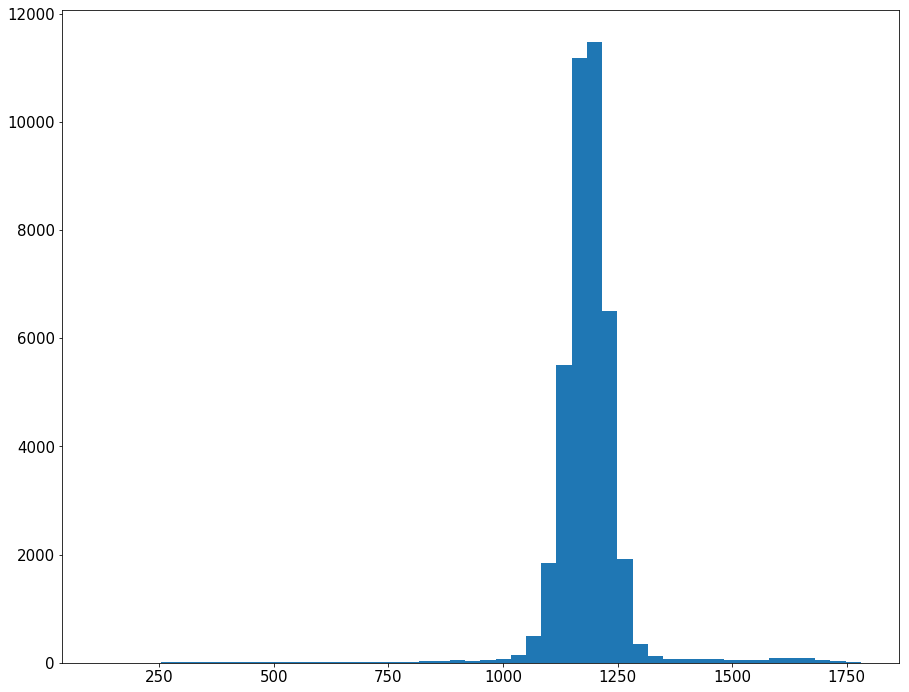

In [24]:
h = plt.hist(sns_response, 50)

(-5, 5)

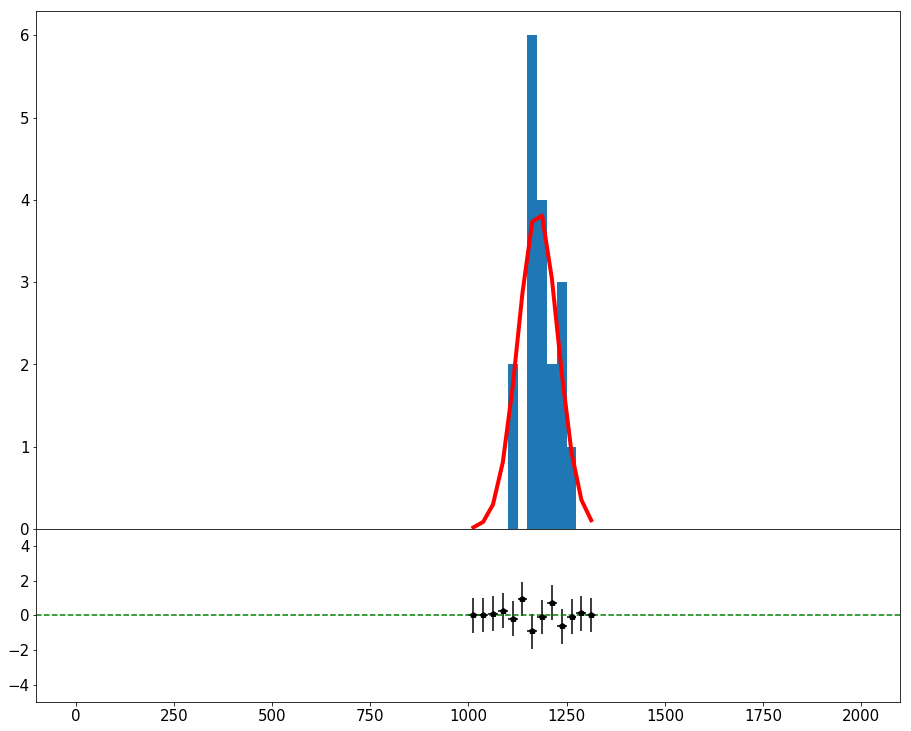

In [25]:
llim =  10,  12.5
rlim = 10, 12.5
sel  = in_range(reco_z, *llim) & in_range(reco_r, *rlim)
e    = sns_response[sel]
#print(e)
range_3 = (0, 2000)

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
y, x, _   = plt.hist(e, 80, range=range_3)
x         = shift_to_bin_centers(x)
seed      = gauss_seed(x, y)
fit_range = seed[1] - 3. * seed[2], seed[1] + 3. * seed[2]
x, y      = x[in_range(x, *fit_range)], y[in_range(x, *fit_range)]
f         = fitf.fit(fitf.gauss, x, y, seed, sigma=poisson_sigma(y))
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)

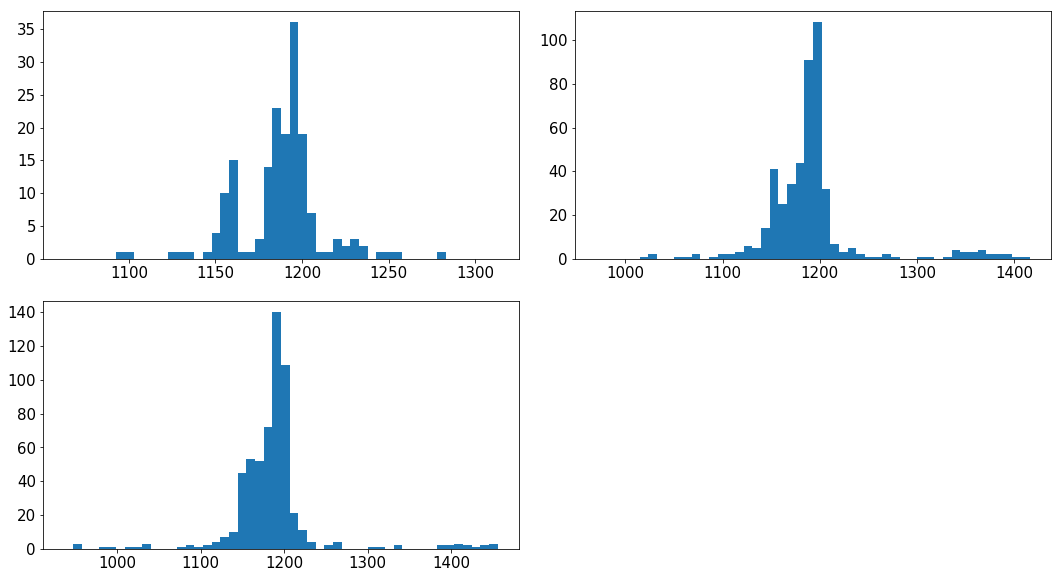

In [26]:
i = 1
for nL, nR in zip(Lnbins, Rnbins):
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    plt.hist(Eave[(nL, nR)].flatten(), 50, (E_min[(nL, nR)], E_max[(nL, nR)]))
    i += 1

plt.tight_layout()

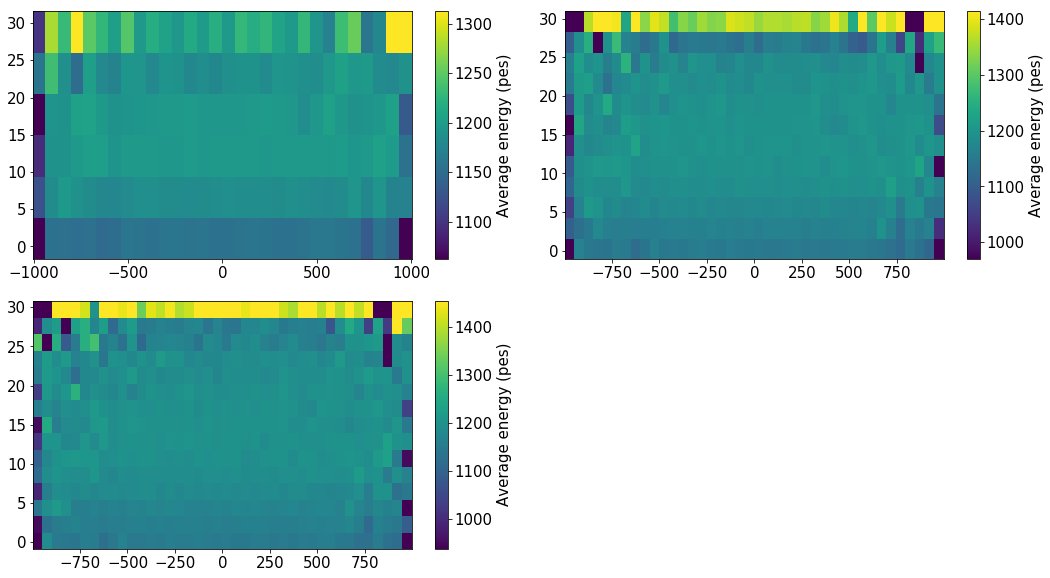

In [27]:
i = 1
for nL, nR in zip(Lnbins, Rnbins):
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    *_, cb = display_matrix(Lcenters[nL], Rcenters[nR], Eave[(nL, nR)],
                            vmin = E_min[(nL, nR)],
                            vmax = E_max[(nL, nR)],
                            cmap = default_cmap)
    cb.set_label("Average energy (pes)")
    i += 1

plt.tight_layout()

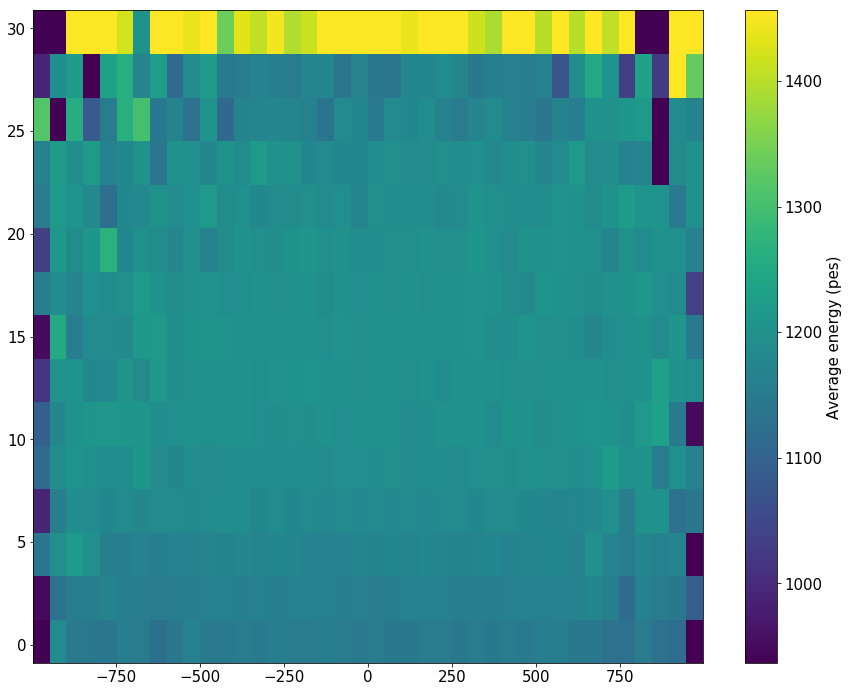

In [29]:
z = 40
r = 15
lpitch = Lpitch[z]
rpitch = Rpitch[r]
*_, cb = display_matrix(Lcenters[z], Rcenters[r], Eave[(z, r)],
                        vmin = E_min[(z, r)],
                        vmax = E_max[(z, r)],
                        cmap = default_cmap)
cb.set_label("Average energy (pes)")

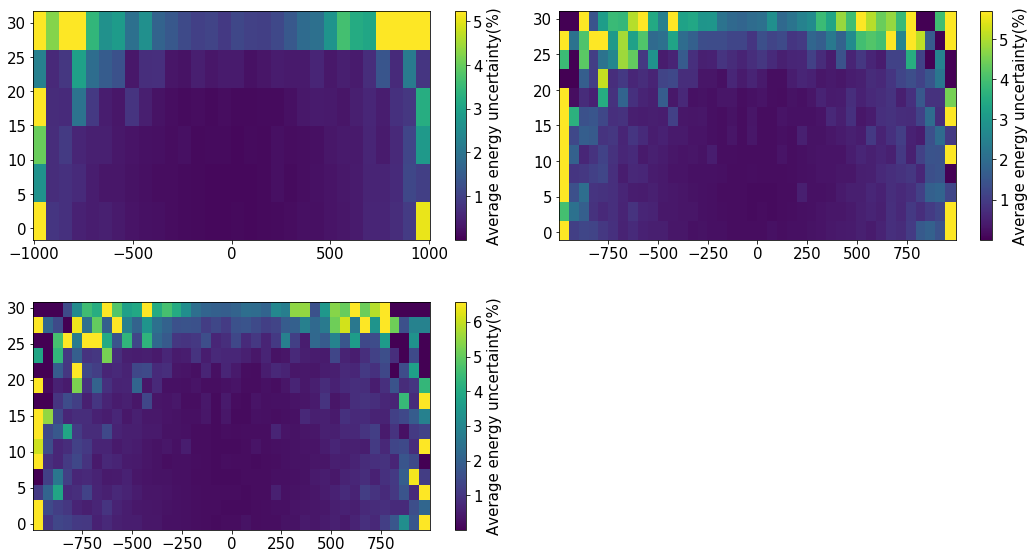

In [30]:
i = 1
for nL, nR in zip(Lnbins, Rnbins):
    lpitch = Lpitch[nL]
    rpitch = Rpitch[nR]
    plt.subplot(3, 2, i)
    *_, cb = display_matrix(Lcenters[nL], Rcenters[nR], Eaveu[(nL, nR)],
                            vmin = Eu_min[(nL, nR)],
                            vmax = Eu_max[(nL, nR)],
                            cmap = default_cmap)
    cb.set_label("Average energy uncertainty(%)")
    i += 1

plt.tight_layout()

### Table at different pitches

In [31]:
class ZRfactors(tb.IsDescription):
    Z            = tb.Float32Col(pos=0)
    R            = tb.Float32Col(pos=1)
    Factor       = tb.Float32Col(pos=2)
    Uncertainty  = tb.Float32Col(pos=3)
    NEvt         = tb. UInt32Col(pos=4)

with tb.open_file(correction_filename, "w") as output_file:
    for nL, nR in zip(Lnbins, Rnbins):
        lpitch = Lpitch[nL]
        rpitch = Rpitch[nR]
        group      = "ZRcorrections"
        table_name = f"GeometryE_{lpitch:.1f}mm_{rpitch:.1f}mm"
        if (group      in output_file.root                 and
            table_name in getattr(output_file.root, group)):
            output_file.remove_node(getattr(output_file.root, group), table_name)
        writer = correction_writer(output_file, group=group, table_name=table_name, 
                                   data_type=ZRfactors,
                                   description='ZR corrections', compression = 'ZLIB4',
                                   x_name = 'Z', y_name = 'R')
        writer(Lcenters[nL], Rcenters[nR], Eave[(nL, nR)], Eaveu[(nL, nR)] * Eave[(nL, nR)] / 100, Nevt[(nL, nR)])

        table = getattr(getattr(output_file.root, group), table_name)
        table.attrs.l_bins  = nL
        table.attrs.r_bins  = nR
        table.attrs.l_pitch = lpitch
        table.attrs.r_pitch = rpitch
        

### Correct the energy

In [32]:
correction_filename

'/Users/paola/prova_thr2.h5'

In [33]:
corrections  = load_corrections(correction_filename,
                                group = "ZRcorrections",
                                node =  "GeometryE_48.6mm_2.0mm",
                                x_name = 'Z',
                                y_name = 'R',
                                norm_strategy = "max")


In [34]:
corr_charge = sns_response * corrections(reco_z, reco_r).value

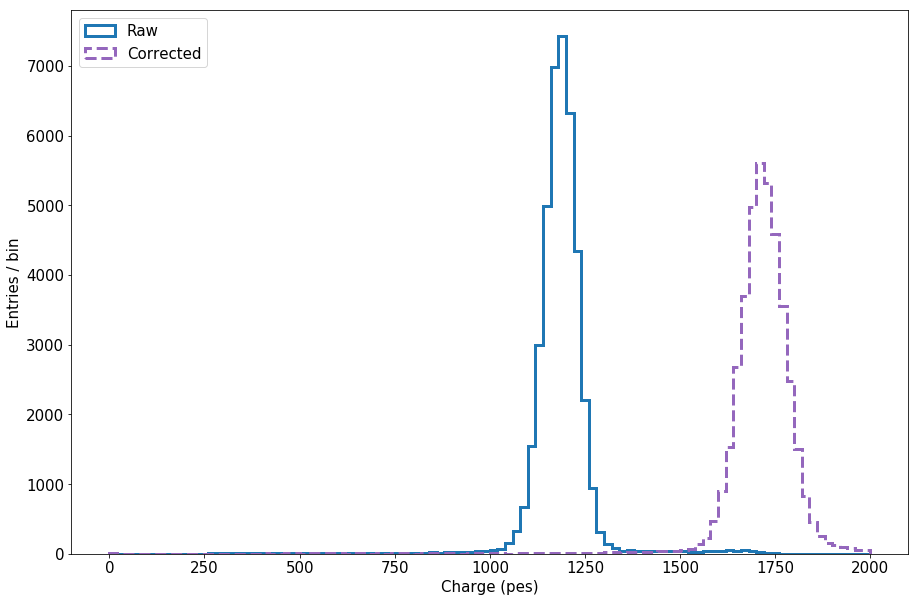

In [35]:
### Different fiducializations in R, constant z
fig = plt.figure(1)
fig.set_figwidth(15.)
fig.set_figheight(10.)

nbins = 100
plot_range = 0, 2200

bins = np.histogram(np.hstack((sns_response, corr_charge)), 
                        bins=nbins, range = (0, 2000))[1] #get the bin edges

h1 = plt.hist(sns_response, bins=bins, color=blue, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Raw', linewidth=3.0,)
h2 = plt.hist(corr_charge, bins=bins, color=purple, range=plot_range, histtype='step', 
              stacked=True, fill=False, label='Corrected', linewidth=3.0, linestyle='--')

lnd = plt.legend(loc=2)
plt.xlabel('Charge (pes)')
plt.ylabel('Entries / bin');